# Preserve a pointwise quantity of interest (QoI) with safeguards

In this example, we compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the log-scale visualisation of a 2D specific humidity slice. Finally we apply safeguards to guarantee an absolute error bound directly on the pointwise quantity of interest, the logarithm that is being visualised. This example thus provides a simple starting point for preserving simple diagnostics and plotting.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import humanize
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-q" / "data.nc")
ERA5_Q = ERA5["q"].sel(valid_time="2024-04-02T12:00:00", pressure_level=850)

In [4]:
def compute_corrections_percentage(
    my_ERA5_Q: xr.DataArray, orig_ERA5_Q: xr.DataArray
) -> float:
    return np.mean(my_ERA5_Q != orig_ERA5_Q)

In [5]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [6]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [7]:
def plot_specific_humidity_log10(
    my_ERA5_Q: xr.DataArray,
    cr,
    chart,
    title,
    span,
    qlog10_eb_abs,
    error=False,
    corr=None,
):
    import copy

    with np.errstate(divide="ignore", invalid="ignore"):
        ERA5_Q_log10 = np.log10(ERA5_Q)
        my_ERA5_Q_log10 = np.log10(my_ERA5_Q)

    if error:
        err_Q_inf = np.amax(np.abs(my_ERA5_Q - ERA5_Q))
        err_Q_log10_inf = np.amax(np.abs(my_ERA5_Q_log10 - ERA5_Q_log10))
        err_Q_log10_fin_inf = np.nanmax(
            np.nan_to_num(
                np.abs(my_ERA5_Q_log10 - ERA5_Q_log10),
                nan=np.nan,
                posinf=np.nan,
                neginf=np.nan,
            )
        )
        err_Q_log10_2 = np.sqrt(np.mean(np.square(my_ERA5_Q_log10 - ERA5_Q_log10)))
        err_Q_log10_fin_2 = np.sqrt(
            np.nanmean(
                np.nan_to_num(
                    np.square(my_ERA5_Q_log10 - ERA5_Q_log10),
                    nan=np.nan,
                    posinf=np.nan,
                    neginf=np.nan,
                )
            )
        )
        err_v = np.mean(~(np.abs(my_ERA5_Q_log10 - ERA5_Q_log10) <= qlog10_eb_abs))

        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_Q_log10 - ERA5_Q_log10).compute()

        da.attrs.update(long_name=f"log10({da.long_name}) error", units=ERA5_Q.units)
    else:
        # plot the decimal logarithm of specific humidity to better capture scale
        da = np.log10(my_ERA5_Q)
        da.attrs.update(long_name=rf"log10({ERA5_Q.long_name})", units=ERA5_Q.units)

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    if error:
        style._levels = earthkit.plots.styles.levels.Levels(
            np.linspace(-span, span, 22)
        )
        style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
        style._colors = "coolwarm"
    else:
        style._levels = earthkit.plots.styles.levels.Levels(np.linspace(*span, 22))
        style._legend_kwargs["ticks"] = np.linspace(*span, 5)
        style._colors = "viridis"

    extend_left = np.nanmin(da) < (-span if error else span[0])
    extend_right = np.nanmax(da) > (span if error else span[1])

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    chart.ax.fill_between(
        [0, 1],
        [1, 1],
        hatch="XX",
        edgecolor="magenta",
        facecolor="lavenderblush",
        transform=chart.ax.transAxes,
        zorder=-12,
    )

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        corr = None if corr is None else compute_corrections_percentage(my_ERA5_Q, corr)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{q}}}})$={err_Q_inf:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{\log_{{{{10}}}}(q)}}}})$={err_Q_log10_inf:.03}"
            + ("" if err_Q_log10_inf != np.inf else f" ({err_Q_log10_fin_inf:.03})")
            + "  "
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                )
            )
            + "\n"
            + rf"$L_{{{{2}}}}(\hat{{{{\log_{{{{10}}}}(q)}}}})$={err_Q_log10_2:.03}"
            + ("" if err_Q_log10_2 != np.inf else f" ({err_Q_log10_fin_2:.03})")
        )
    else:
        chart.title(f"{title}\n")

    t = chart.ax.text(
        0.95,
        0.9,
        f"x {np.round(cr, 2)}"
        if error
        else humanize.naturalsize(ERA5_Q.nbytes, binary=True),
        ha="right",
        va="top",
        transform=chart.ax.transAxes,
    )
    t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(
        da.values.flatten(),
        range=(-span if error else span[0], span if error else span[1]),
        bins=21,
    )
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[1].colorbar
    extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
    cax = cb.ax.inset_axes(
        [
            0.0 - extend_width * extend_left,
            1.25,
            1.0
            + extend_width
            * (0 + extend_left + extend_right + np.any(np.isnan(da)) * 2),
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    if extend_left:
        cax.bar(
            bins[0] - (bins[1] - bins[0]) / 2,
            height=np.sum(da < (-span if error else span[0])),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[0])),
        )
    if extend_right:
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) / 2,
            height=np.sum(da > (span if error else span[1])),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[-1])),
        )
    if np.any(np.isnan(da)):
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) * (extend_right * 2 + 2 + 1) / 2,
            height=np.sum(np.isnan(da)),
            width=(bins[-1] - bins[0]) / len(counts),
            color="lavenderblush",
            edgecolor="magenta",
            lw=0,
            hatch="XXXX",
        )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(
        (-span if error else span[0]) - (bins[-1] - bins[-2]) * extend_left,
        (span if error else span[1])
        + (bins[-1] - bins[-2]) * (0 + extend_right + np.any(np.isnan(da)) * 2),
    )
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

## Compressing q with lossy compressors

We configure each compressor with an absolute error bound of $5 \cdot 10^{-4}$ kg/kg, which produces decent compression ratios and shows that ZFP, SZ3 and ZFP can produce negative values whose logarithm is undefined.

In [8]:
eb_abs = 0.0005

In [9]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

ERA5_Q_zfp_enc = zfp.encode(ERA5_Q.values)
ERA5_Q_zfp = ERA5_Q.copy(data=zfp.decode(ERA5_Q_zfp_enc))

ERA5_Q_zfp_cr = ERA5_Q.nbytes / ERA5_Q_zfp_enc.nbytes

In [10]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

ERA5_Q_sz3_enc = sz3.encode(ERA5_Q.values)
ERA5_Q_sz3 = ERA5_Q.copy(data=sz3.decode(ERA5_Q_sz3_enc))

ERA5_Q_sz3_cr = ERA5_Q.nbytes / ERA5_Q_sz3_enc.nbytes

In [11]:
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

ERA5_Q_sperr_enc = sperr.encode(ERA5_Q.values)
ERA5_Q_sperr = ERA5_Q.copy(data=sperr.decode(ERA5_Q_sperr_enc))

ERA5_Q_sperr_cr = ERA5_Q.nbytes / ERA5_Q_sperr_enc.nbytes

In [12]:
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

ERA5_Q_zero_enc = zero.encode(ERA5_Q.values)
ERA5_Q_zero = ERA5_Q.copy(data=zero.decode(ERA5_Q_zero_enc))

## Compressing q using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the decimal logarithm diagnostic, choosing an error bound of 0.25 (in logarithmic space).

In [13]:
qlog10_eb_abs = 0.25

In [14]:
from numcodecs_safeguards import SafeguardsCodec

ERA5_Q_sg = dict()
ERA5_Q_sg_cr = dict()

for codec in [
    zero,
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_pw",
                qoi="log10(x)",
                type="abs",
                eb=qlog10_eb_abs,
            )
        ],
    )

    ERA5_Q_sg_enc = sg.encode(ERA5_Q.values)
    ERA5_Q_sg[codec.codec_id] = ERA5_Q.copy(data=sg.decode(ERA5_Q_sg_enc))

    ERA5_Q_sg_cr[codec.codec_id] = ERA5_Q.nbytes / np.asarray(ERA5_Q_sg_enc).nbytes

## Visual comparison of the error distributions for the logarithm diagnostic

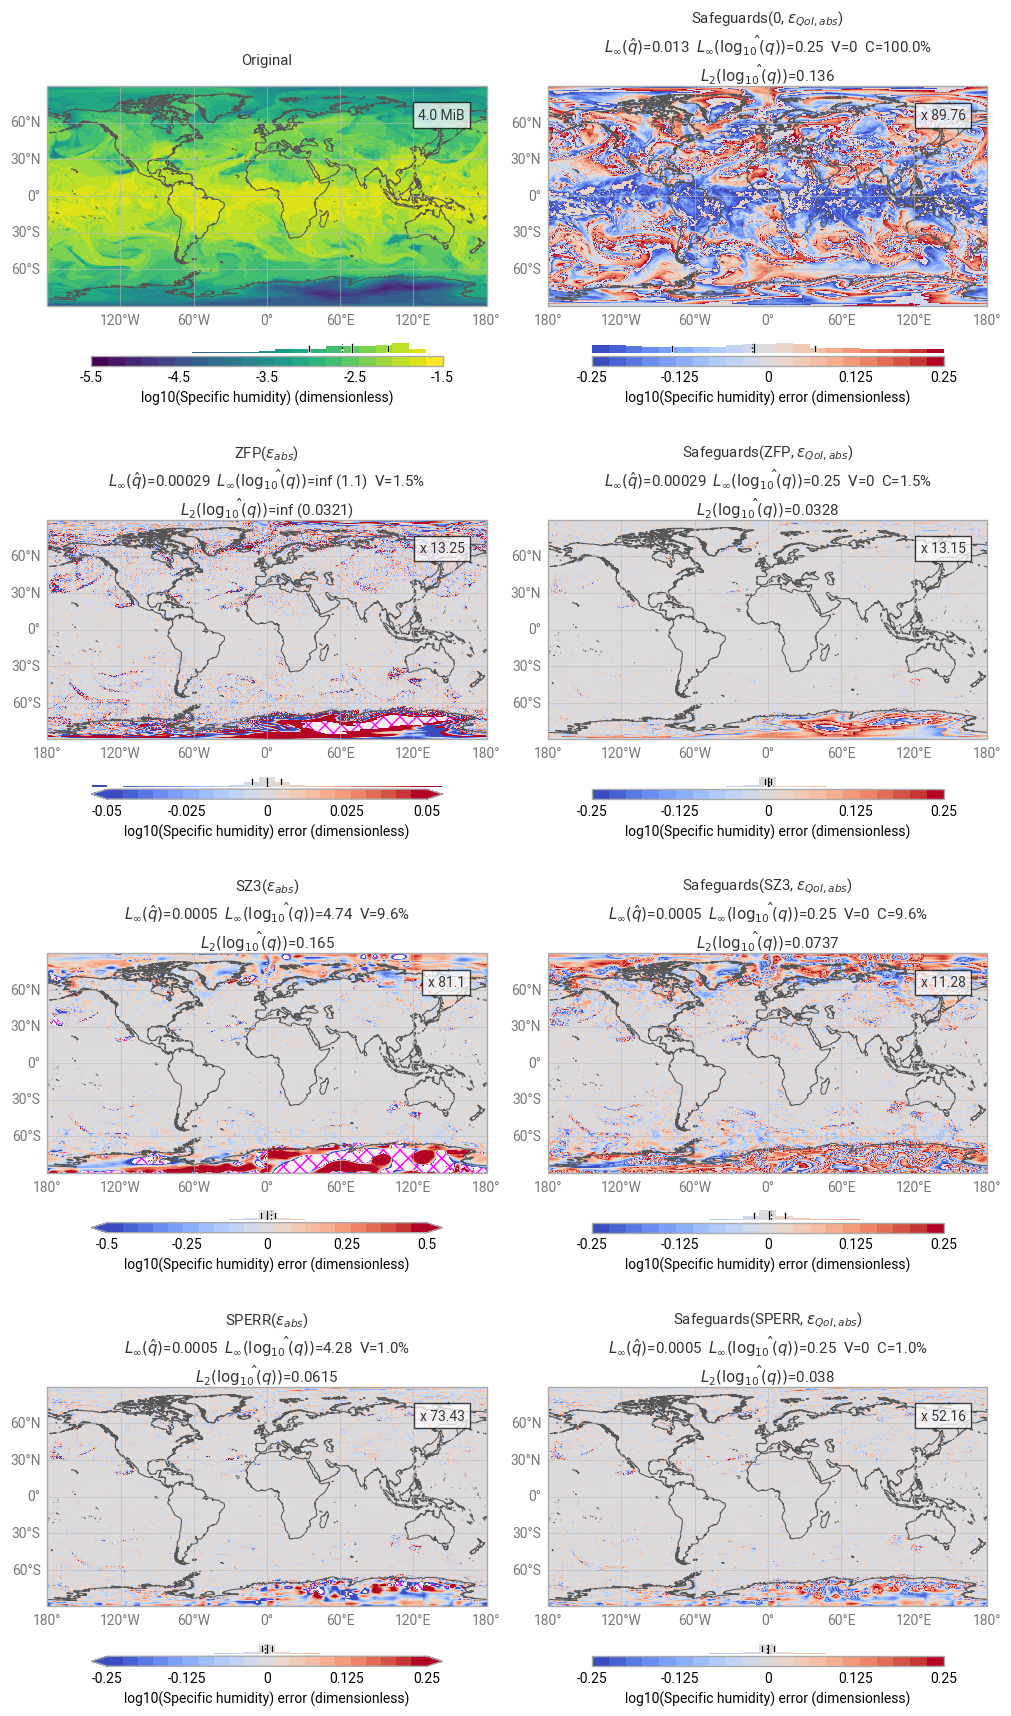

In [15]:
fig = earthkit.plots.Figure(
    size=(10, 17),
    rows=4,
    columns=2,
    hspace=0.1,
)

plot_specific_humidity_log10(
    ERA5_Q,
    1.0,
    fig.add_map(0, 0),
    "Original",
    span=(-5.5, -1.5),
    qlog10_eb_abs=qlog10_eb_abs,
)
plot_specific_humidity_log10(
    ERA5_Q_zfp,
    ERA5_Q_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    span=0.05,
    qlog10_eb_abs=qlog10_eb_abs,
    error=True,
)
plot_specific_humidity_log10(
    ERA5_Q_sz3,
    ERA5_Q_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    span=0.5,
    qlog10_eb_abs=qlog10_eb_abs,
    error=True,
)
plot_specific_humidity_log10(
    ERA5_Q_sperr,
    ERA5_Q_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    span=0.25,
    qlog10_eb_abs=qlog10_eb_abs,
    error=True,
)

plot_specific_humidity_log10(
    ERA5_Q_sg["zero"],
    ERA5_Q_sg_cr["zero"],
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
    span=qlog10_eb_abs,
    qlog10_eb_abs=qlog10_eb_abs,
    error=True,
    corr=ERA5_Q_zero,
)
plot_specific_humidity_log10(
    ERA5_Q_sg["zfp.rs"],
    ERA5_Q_sg_cr["zfp.rs"],
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
    span=qlog10_eb_abs,
    qlog10_eb_abs=qlog10_eb_abs,
    error=True,
    corr=ERA5_Q_zfp,
)
plot_specific_humidity_log10(
    ERA5_Q_sg["sz3.rs"],
    ERA5_Q_sg_cr["sz3.rs"],
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
    span=qlog10_eb_abs,
    qlog10_eb_abs=qlog10_eb_abs,
    error=True,
    corr=ERA5_Q_sz3,
)
plot_specific_humidity_log10(
    ERA5_Q_sg["sperr.rs"],
    ERA5_Q_sg_cr["sperr.rs"],
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
    span=qlog10_eb_abs,
    qlog10_eb_abs=qlog10_eb_abs,
    error=True,
    corr=ERA5_Q_sperr,
)

fig.save("specific-humidity-log10.pdf")

In this simple case of a $\text{QoI} = \log_{10}(x)$ diagnostic safeguard with $\epsilon_{abs}(\text{QoI}) \leq 0.25$, we could have also used a ratio error bound with $\epsilon_{ratio} = 10^{0.25}$ without a quantity of interest. Using an equivalent but simpler safeguard can sometimes result in higher compression ratios (e.g. using `qoi="log(x, base=10)"` results in a lower compression ratio):

In [16]:
sg_ratio = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(
            kind="eb",
            type="ratio",
            eb=np.power(10.0, qlog10_eb_abs),
        )
    ],
)

In [17]:
ERA5_Q_sg_ratio_enc = sg_ratio.encode(ERA5_Q.values)
ERA5_Q_sg_ratio = ERA5_Q.copy(data=sg_ratio.decode(ERA5_Q_sg_ratio_enc))

ERA5_Q_sg_ratio_cr = ERA5_Q.nbytes / np.asarray(ERA5_Q_sg_ratio_enc).nbytes

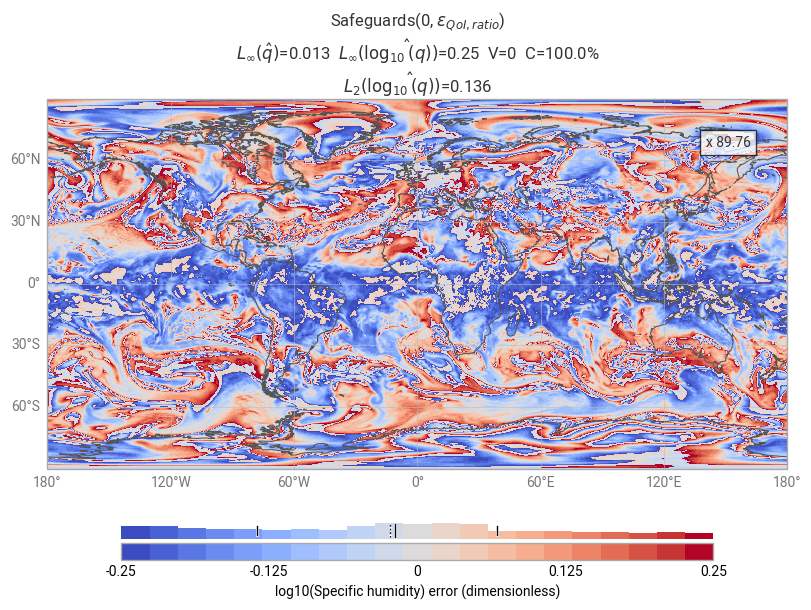

In [18]:
chart = earthkit.plots.Map()

plot_specific_humidity_log10(
    ERA5_Q_sg_ratio,
    ERA5_Q_sg_ratio_cr,
    chart,
    r"Safeguards(0, $\epsilon_{{QoI,ratio}}$)",
    span=qlog10_eb_abs,
    qlog10_eb_abs=qlog10_eb_abs,
    error=True,
    corr=ERA5_Q_zero,
)

chart.save("specific-humidity-ratio.pdf")